## Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk import word_tokenize, Text
import re
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

## Transfer Timestamp into datetime

In [2]:
df = pd.read_csv('../data/clean_data/clean_data_annotated.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'],format='"%Y-%m-%d %H:%M"')#"2020-07-31 11:45"
df.head(5)

,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
0,Michael Lewis & Friends,@Michael65413248,2020-07-31 11:45:00,Bloggers commented on #COVID19SG #COVID19Singa...,79.0,41.0,0,0.0,GE2020SG,0.318450,-1.850372e-17,0.6369,pos,neg,pos
1,harish on wafto,@harishpillay,2020-07-30 07:37:00,They feel that they can just keep the narrativ...,0.0,1.0,0,0.0,GE2020SG,-0.477729,-1.428571e-01,-0.8126,neg,neg,neg
2,Angry Merlion,@jj09102010,2020-07-25 04:25:00,The legend of #singapore opposition movement. ...,0.0,0.0,0,0.0,GE2020SG,0.000000,0.000000e+00,0.0000,neutral,neutral,neutral
3,SUTD Singapore,@sutdsg,2020-07-22 08:30:00,"Regardless of race, language, or religion - th...",0.0,1.0,0,0.0,GE2020SG,-0.116667,-2.333333e-01,0.0000,neg,neg,neutral
4,Karen M. Fu,@karen_fu,2020-07-20 08:49:00,Senior Minister Tharman Shanmugaratnam comment...,0.0,0.0,0,0.0,GE2020SG,0.290900,2.000000e-01,0.3818,pos,pos,pos


## Tweets preprocessing

In [3]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)

    return input_txt
df['Content'] = np.vectorize(remove_pattern)(df['Content'], "#[\w]*")#remove hashtag
df['Content'] = np.vectorize(remove_pattern)(df['Content'], "@[\w]*")#remove @
df

,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
0,Michael Lewis & Friends,@Michael65413248,2020-07-31 11:45:00,Bloggers commented on & went missing befo...,79.0,41.0,0,0.0,GE2020SG,0.318450,-1.850372e-17,0.6369,pos,neg,pos
1,harish on wafto,@harishpillay,2020-07-30 07:37:00,They feel that they can just keep the narrativ...,0.0,1.0,0,0.0,GE2020SG,-0.477729,-1.428571e-01,-0.8126,neg,neg,neg
2,Angry Merlion,@jj09102010,2020-07-25 04:25:00,The legend of opposition movement.,0.0,0.0,0,0.0,GE2020SG,0.000000,0.000000e+00,0.0000,neutral,neutral,neutral
3,SUTD Singapore,@sutdsg,2020-07-22 08:30:00,"Regardless of race, language, or religion - th...",0.0,1.0,0,0.0,GE2020SG,-0.116667,-2.333333e-01,0.0000,neg,neg,neutral
4,Karen M. Fu,@karen_fu,2020-07-20 08:49:00,Senior Minister Tharman Shanmugaratnam comment...,0.0,0.0,0,0.0,GE2020SG,0.290900,2.000000e-01,0.3818,pos,pos,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8765,thisandthat,@38thisandthat,2020-07-10 01:07:00,: What to do on Polling DaySingapore GE2020: ...,0.0,0.0,0,0.0,Ge2020,0.329850,0.000000e+00,0.6597,pos,neutral,pos
8766,The Business Times,@BusinessTimes,2020-07-10 00:43:00,: \n\n urges voters to imagine a that is 'far...,1.0,3.0,0,0.0,Ge2020,0.050000,1.000000e-01,0.0000,pos,pos,neutral
8767,Cherian George,@cheriangeorge,2020-07-10 00:15:00,Understated auto-response to http://Academia.S...,10.0,83.0,0,1.0,Ge2020,-0.120033,-2.916667e-01,0.0516,neg,neg,pos
8768,ராஜேஷ்,@RajeshChakram,2020-07-10 00:03:00,Good luck \nGood luck \n\n\nVotes\n\nElection,1.0,0.0,0,1.0,Ge2020,0.359200,0.000000e+00,0.7184,pos,neutral,pos


In [4]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def preprocess(text):
    # Clean the text

    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r'''(?i)\b((?:http?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"[^a-zA-Z#]"," ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)  
    filtered_words = [w.lower() for w in tokens if not w.lower() in stopwords.words('english')] 
#     stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)

In [5]:
df['Content'] = df['Content'].apply(preprocess)
df.head(5)

,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
0,Michael Lewis & Friends,@Michael65413248,2020-07-31 11:45:00,blogger commented went missing july an activel...,79.0,41.0,0,0.0,GE2020SG,0.318450,-1.850372e-17,0.6369,pos,neg,pos
1,harish on wafto,@harishpillay,2020-07-30 07:37:00,feel keep narrative deny everything else showe...,0.0,1.0,0,0.0,GE2020SG,-0.477729,-1.428571e-01,-0.8126,neg,neg,neg
2,Angry Merlion,@jj09102010,2020-07-25 04:25:00,legend opposition movement,0.0,0.0,0,0.0,GE2020SG,0.000000,0.000000e+00,0.0000,neutral,neutral,neutral
3,SUTD Singapore,@sutdsg,2020-07-22 08:30:00,regardless race language religion topic race l...,0.0,1.0,0,0.0,GE2020SG,-0.116667,-2.333333e-01,0.0000,neg,neg,neutral
4,Karen M. Fu,@karen_fu,2020-07-20 08:49:00,senior minister tharman shanmugaratnam comment...,0.0,0.0,0,0.0,GE2020SG,0.290900,2.000000e-01,0.3818,pos,pos,pos


In [6]:
df['Content'] = df['Content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2 or w=='wp' or w=='rp']))
df.head()

,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
0,Michael Lewis & Friends,@Michael65413248,2020-07-31 11:45:00,blogger commented went missing july actively s...,79.0,41.0,0,0.0,GE2020SG,0.318450,-1.850372e-17,0.6369,pos,neg,pos
1,harish on wafto,@harishpillay,2020-07-30 07:37:00,feel keep narrative deny everything else showe...,0.0,1.0,0,0.0,GE2020SG,-0.477729,-1.428571e-01,-0.8126,neg,neg,neg
2,Angry Merlion,@jj09102010,2020-07-25 04:25:00,legend opposition movement,0.0,0.0,0,0.0,GE2020SG,0.000000,0.000000e+00,0.0000,neutral,neutral,neutral
3,SUTD Singapore,@sutdsg,2020-07-22 08:30:00,regardless race language religion topic race l...,0.0,1.0,0,0.0,GE2020SG,-0.116667,-2.333333e-01,0.0000,neg,neg,neutral
4,Karen M. Fu,@karen_fu,2020-07-20 08:49:00,senior minister tharman shanmugaratnam comment...,0.0,0.0,0,0.0,GE2020SG,0.290900,2.000000e-01,0.3818,pos,pos,pos


## A brief analysis of extracted tweets

In [7]:
df['Timestamp'].value_counts()

2020-05-08 20:30:00    36
2020-07-11 03:38:00    17
2020-05-07 07:20:00    14
2020-05-08 20:08:00    13
2020-07-11 02:40:00    12
                       ..
2020-05-24 09:24:00     1
2020-05-08 03:02:00     1
2020-07-08 09:48:00     1
2020-07-10 01:01:00     1
2020-06-23 04:07:00     1
Name: Timestamp, Length: 5412, dtype: int64

In [8]:
df.groupby([df['Timestamp'].dt.month]).agg({'count'})

,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count
Timestamp,,,,,,,,,,,,,,,
5,1176,1181,1181,1181,1181,1181,1181,1181,1181,1181,1181,1181,1181,1181,1181
6,1437,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439,1439
7,6140,6150,6150,6150,6150,6150,6150,6150,6150,6150,6150,6150,6150,6150,6150


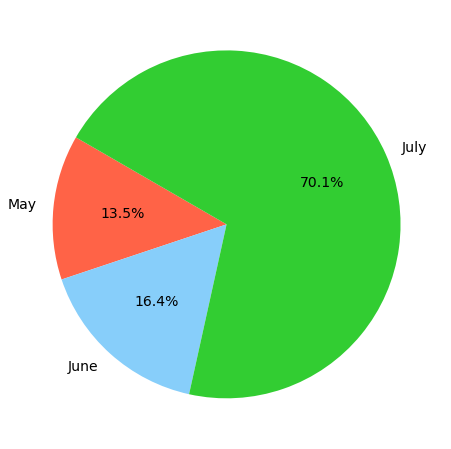

In [9]:
# Tweet number by month
month = ['May','June','July']
sizes = [1181,1439,6150]

fig = plt.figure(figsize=(16,8))
colors = ['tomato','lightskyblue','limegreen']
plt.pie(sizes,labels=month,colors=colors,autopct='%1.1f%%',shadow=False,startangle=150,textprops={'fontsize':14})
plt.show()

fig.savefig('../img/tweet_number_by_month.png', dpi=600, bbox_inches='tight', transparent=True)

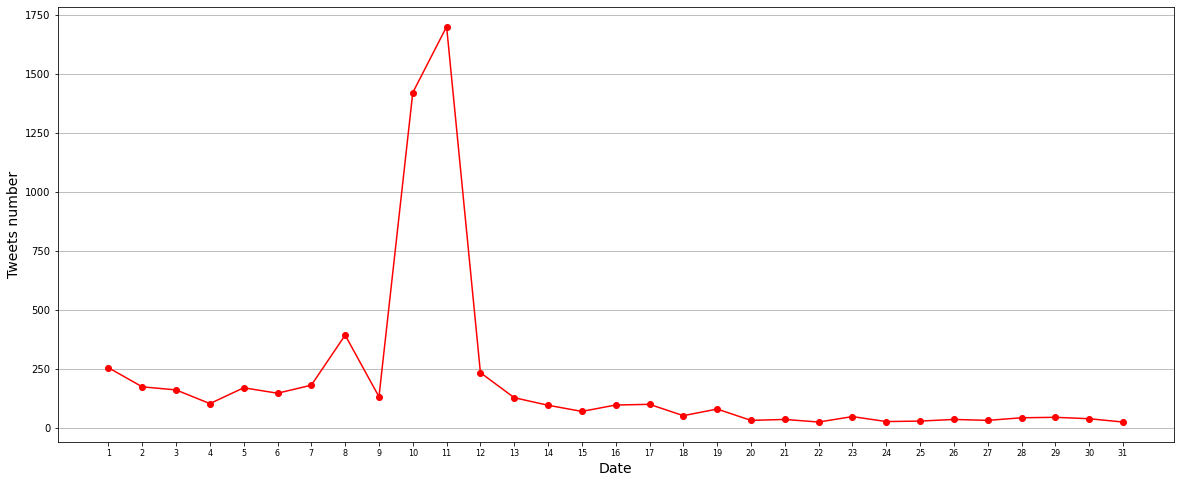

In [10]:
#Tweets in July
df1 = df[df['Timestamp'].dt.month==7]
b = df1.groupby([df['Timestamp'].dt.day]).agg({'count'})
count = b.iloc[:,0]
day = []
for i in range(1,32):
    day.append(str(i))

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(day, count, color='#ff0000', marker='o')
ax.set_xticklabels(day, fontsize=8)
ax.set_ylabel('Tweets number', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

fig.savefig('../img/Tweets_by_date.png', bbox_inches='tight', dpi=600, transparent=True)

## Analysis of all tweets

In [11]:
# merge the tweets content into a text
text = []
for row in df.itertuples():
    i = getattr(row, 'Content')
    text.append(i)
text = ' '.join(text)
wordlists = word_tokenize(text)
text = nltk.Text(wordlists)
type(text)

nltk.text.Text

In [12]:
### shows the frequency of each item in the text
fdist = nltk.FreqDist(text)
fdist.most_common(10)

[('election', 5173),
 ('singapore', 4999),
 ('general', 3949),
 ('party', 1753),
 ('pap', 1478),
 ('vote', 1362),
 ('com', 892),
 ('result', 826),
 ('opposition', 698),
 ('day', 675)]

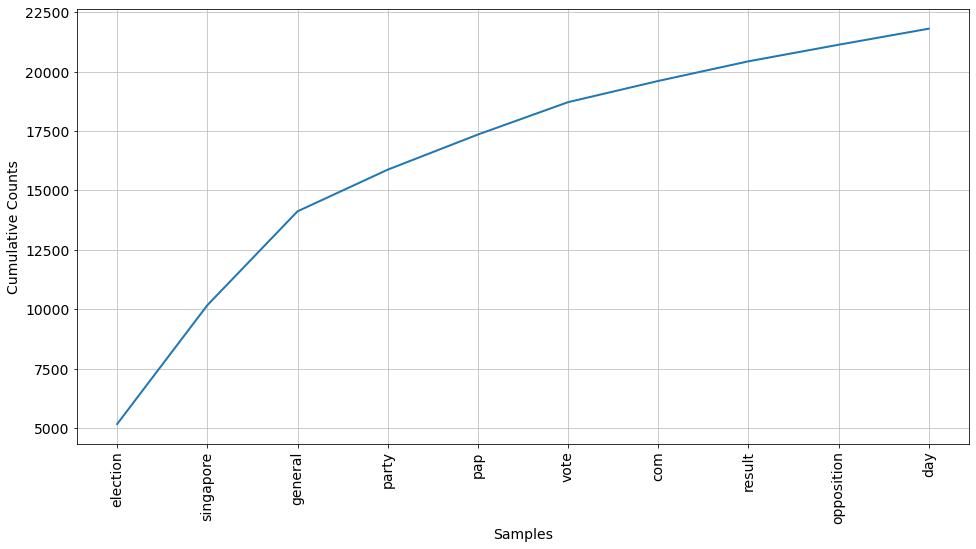

In [13]:
# generate a cumulative frequency plot to determine proportion of the text taken up by the words
%matplotlib inline
fig = plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 14})
fdist.plot(10, cumulative=True)
fig.savefig("../img/fdist.png",dpi=600, bbox_inches='tight')

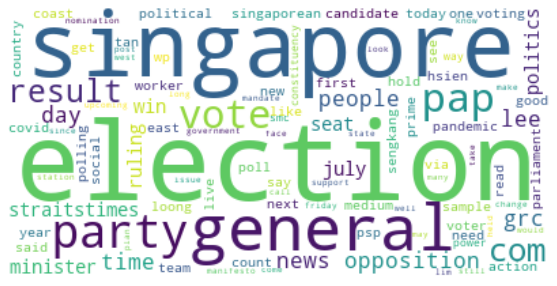

In [14]:
# generate a wordcloud
dictionary=Counter(text)
cloud = WordCloud(max_font_size=80,background_color='white', max_words=100).generate_from_frequencies(dictionary)
fig = plt.figure(figsize=(10,5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
fig.savefig("../img/wordcloud.png",dpi=600, bbox_inches='tight')

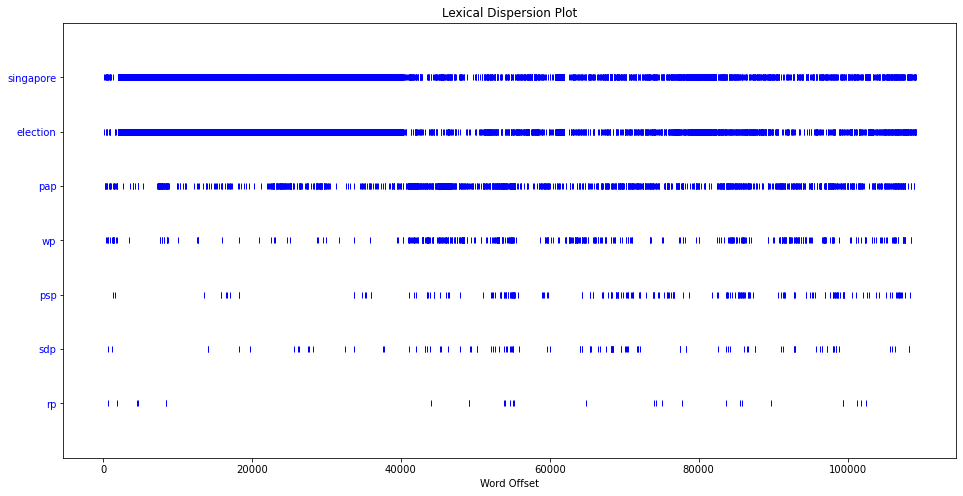

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(16,8))
text.dispersion_plot(["singapore", "election", "pap", "wp", "psp", "sdp", "rp"])
fig.savefig('../img/dispersion_plot.png', transparent=True, bbox_inches='tight')

In [16]:
# bigrams of tweets
bigrams = nltk.bigrams(text)
cfd = nltk.ConditionalFreqDist(bigrams)
dist = cfd['pap']
dist.most_common(10)

[('win', 112),
 ('candidate', 54),
 ('psp', 42),
 ('wp', 34),
 ('team', 32),
 ('supporter', 28),
 ('conservative', 27),
 ('singapore', 25),
 ('seat', 22),
 ('party', 19)]

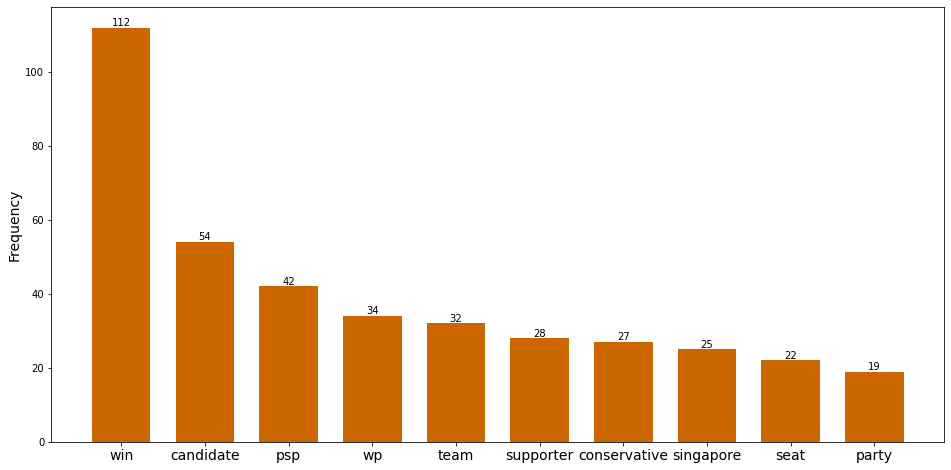

In [17]:
words = ['win', 'candidate', 'psp', 'wp', 'team', 'supporter', 'conservative', 'singapore', 'seat', 'party']
data = [112,54,42,34,32,28,27,25,22,19]

ind = np.arange(len(words))
width = 0.7   
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
yvals = data
rects1 = ax.bar(ind, yvals, width, color='#cc6600')
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(words, fontsize=14)

def autolabel(rects): #put number above bar 
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1*h, h,
                ha='center', va='bottom')
autolabel(rects1) 
plt.show()
fig.savefig('../img/pap_bigram.png', transparent=True, bbox_inches='tight')

In [18]:
# bigrams of tweets
bigrams = nltk.bigrams(text)
cfd = nltk.ConditionalFreqDist(bigrams)
dist = cfd['wp']
dist.most_common(10)

[('pap', 24),
 ('win', 23),
 ('chief', 23),
 ('centre', 22),
 ('east', 17),
 ('wp', 16),
 ('sengkang', 15),
 ('candidate', 9),
 ('psp', 8),
 ('sdp', 8)]

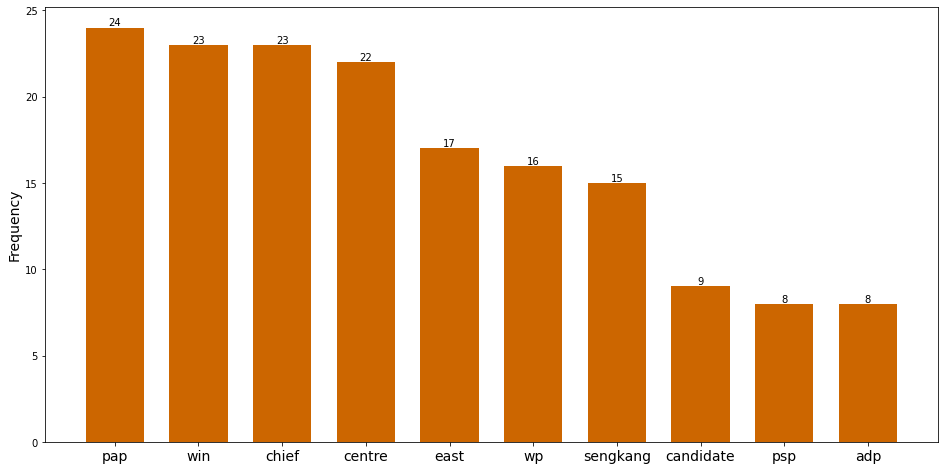

In [19]:
words = ['pap', 'win', 'chief', 'centre', 'east', 'wp', 'sengkang', 'candidate', 'psp', 'adp']
data = [24,23,23,22,17,16,15,9,8,8]

ind = np.arange(len(words))
width = 0.7   
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
yvals = data
rects1 = ax.bar(ind, yvals, width, color='#cc6600')
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(words, fontsize=14)

def autolabel(rects): #put number above bar 
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2, 1*h, h,
                ha='center', va='bottom')
autolabel(rects1) 
plt.show()
fig.savefig('../img/wp_bigram.png', transparent=True, bbox_inches='tight')

## Wordcloud of positive tweets

In [20]:
df1 = df[df['Sentiment']=='pos']
df1

,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
0,Michael Lewis & Friends,@Michael65413248,2020-07-31 11:45:00,blogger commented went missing july actively s...,79.0,41.0,0,0.0,GE2020SG,0.318450,-1.850372e-17,0.6369,pos,neg,pos
4,Karen M. Fu,@karen_fu,2020-07-20 08:49:00,senior minister tharman shanmugaratnam comment...,0.0,0.0,0,0.0,GE2020SG,0.290900,2.000000e-01,0.3818,pos,pos,pos
9,Credendo,@CredendoEN,2020-07-16 10:10:00,strong economic fundamental ample government s...,0.0,1.0,0,0.0,GE2020SG,0.402239,2.777778e-01,0.5267,pos,pos,pos
10,Karen M. Fu,@karen_fu,2020-07-16 01:09:00,better understand millennials win back say amb...,0.0,0.0,0,0.0,GE2020SG,0.107143,2.142857e-01,0.0000,pos,pos,neutral
15,bakkwabeelee,@muipo1,2020-07-12 08:02:00,remember pmd dialogue ballot box powerful tool,0.0,2.0,0,0.0,GE2020SG,0.360750,3.000000e-01,0.4215,pos,pos,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8764,The Political Geek,@politic_geek,2020-07-10 01:08:00,voting begun see people streaming polling stat...,25.0,122.0,0,3.0,Ge2020,0.502617,4.333333e-01,0.5719,pos,pos,pos
8765,thisandthat,@38thisandthat,2020-07-10 01:07:00,polling daysingapore polling day politics news...,0.0,0.0,0,0.0,Ge2020,0.329850,0.000000e+00,0.6597,pos,neutral,pos
8766,The Business Times,@BusinessTimes,2020-07-10 00:43:00,urge voter imagine far better,1.0,3.0,0,0.0,Ge2020,0.050000,1.000000e-01,0.0000,pos,pos,neutral
8768,ராஜேஷ்,@RajeshChakram,2020-07-10 00:03:00,good luck good luck vote election,1.0,0.0,0,1.0,Ge2020,0.359200,0.000000e+00,0.7184,pos,neutral,pos


In [21]:
# merge the tweets content into a text
text = []
for row in df1.itertuples():
    i = getattr(row, 'Content')
    text.append(i)
text = ' '.join(text)
wordlists = word_tokenize(text)
text = nltk.Text(wordlists)
type(text)

nltk.text.Text

In [22]:
### shows the frequency of each item in the text
fdist = nltk.FreqDist(text)
fdist.most_common(10)

[('singapore', 1969),
 ('election', 1939),
 ('general', 1452),
 ('party', 845),
 ('vote', 650),
 ('pap', 539),
 ('com', 414),
 ('opposition', 364),
 ('result', 363),
 ('people', 326)]

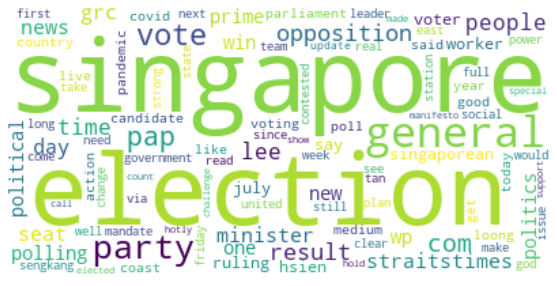

In [23]:
# generate a wordcloud
dictionary=Counter(text)
cloud = WordCloud(max_font_size=80,background_color='white', max_words=100).generate_from_frequencies(dictionary)
fig = plt.figure(figsize=(10,5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
fig.savefig("../img/wordcloud_pos.png",dpi=600, bbox_inches='tight')

## Wordcloud of negative tweets

In [24]:
df2 = df[df['Sentiment']=='neg']
df2

,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
1,harish on wafto,@harishpillay,2020-07-30 07:37:00,feel keep narrative deny everything else showe...,0.0,1.0,0,0.0,GE2020SG,-0.477729,-0.142857,-0.8126,neg,neg,neg
3,SUTD Singapore,@sutdsg,2020-07-22 08:30:00,regardless race language religion topic race l...,0.0,1.0,0,0.0,GE2020SG,-0.116667,-0.233333,0.0000,neg,neg,neutral
6,Karen M. Fu,@karen_fu,2020-07-19 11:32:00,well knew risk best could,0.0,0.0,0,0.0,GE2020SG,-0.136600,0.000000,-0.2732,neg,neutral,neg
11,mrbrown,@mrbrown,2020-07-15 09:09:00,kim huat score winner loser critical exam,15.0,96.0,0,0.0,GE2020SG,-0.113150,0.000000,-0.2263,neg,neutral,neg
14,the political cat,@theMmcat,2020-07-12 10:22:00,without doubt china biggest strategic challege...,0.0,0.0,0,0.0,GE2020SG,-0.180600,0.000000,-0.3612,neg,neutral,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8735,Richard Lim,@rltl17,2020-07-10 08:20:00,pandemic precaution lack rally aside like elec...,1.0,0.0,0,1.0,Ge2020,-0.354811,-0.097222,-0.6124,neg,neg,neg
8753,ANFREL,@Anfrel,2020-07-10 04:01:00,singaporean wearing mask glove cast ballot fri...,1.0,1.0,0,0.0,Ge2020,-0.346150,-0.150000,-0.5423,neg,neg,neg
8758,ANFREL,@Anfrel,2020-07-10 02:31:00,senior assigned voting time band morning polli...,1.0,1.0,0,0.0,Ge2020,-0.250000,-0.500000,0.0000,neg,neg,neutral
8761,Saleena Saleem,@saleena_saleem,2020-07-10 02:07:00,may choice reflect hope fear nelson mandela,1.0,1.0,0,0.0,Ge2020,-0.246950,0.000000,-0.4939,neg,neutral,neg


In [25]:
# merge the tweets content into a text
text = []
for row in df2.itertuples():
    i = getattr(row, 'Content')
    text.append(i)
text = ' '.join(text)
wordlists = word_tokenize(text)
text = nltk.Text(wordlists)
type(text)

nltk.text.Text

In [26]:
### shows the frequency of each item in the text
fdist = nltk.FreqDist(text)
fdist.most_common(10)

[('election', 742),
 ('singapore', 725),
 ('pap', 452),
 ('general', 444),
 ('party', 346),
 ('com', 248),
 ('vote', 230),
 ('news', 191),
 ('opposition', 176),
 ('people', 164)]

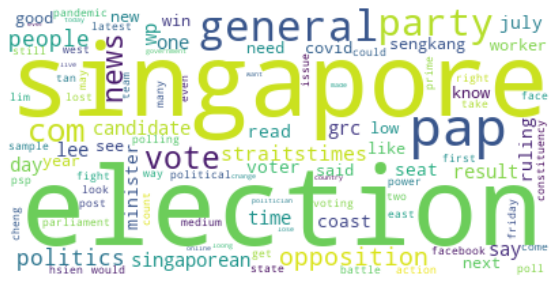

In [27]:
# generate a wordcloud
dictionary=Counter(text)
cloud = WordCloud(max_font_size=80,background_color='white', max_words=100).generate_from_frequencies(dictionary)
fig = plt.figure(figsize=(10,5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
fig.savefig("../img/wordcloud_neg.png",dpi=600, bbox_inches='tight')

## Wordcloud of neutral tweets

In [28]:
df3 = df[df['Sentiment']=='neutral']
df3

,UserName,Handle,Timestamp,Content,Likes,Retweets,Emojis,Comments,Tag,sentiment_scores,Textblob_sentiment_scores,Vader_sentiment_scores,Sentiment,Textblob_sentiment,Vader_sentiment
2,Angry Merlion,@jj09102010,2020-07-25 04:25:00,legend opposition movement,0.0,0.0,0,0.0,GE2020SG,0.0,0.0,0.0,neutral,neutral,neutral
5,Pantheon Percussion,@PantheonPercuss,2020-07-19 10:17:00,wokfunk make repost jamus korkor respond colla...,0.0,0.0,0,0.0,GE2020SG,0.0,0.0,0.0,neutral,neutral,neutral
7,xxx65,@WahLau13,2020-07-19 09:52:00,cecum,0.0,0.0,0,0.0,GE2020SG,0.0,0.0,0.0,neutral,neutral,neutral
8,Aj Morris,@ajishhhh,2020-07-17 07:34:00,wonder kena first pofma post,0.0,0.0,0,0.0,GE2020SG,0.0,0.0,0.0,neutral,neutral,neutral
12,KY,@republicocities,2020-07-15 02:56:00,indeed dare,0.0,0.0,0,0.0,GE2020SG,0.0,0.0,0.0,neutral,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8739,hongrui,@hongruilee,2020-07-10 06:27:00,voted singapore,0.0,1.0,0,0.0,Ge2020,0.0,0.0,0.0,neutral,neutral,neutral
8748,Curtis S. Chin,@CurtisSChin,2020-07-10 04:35:00,five year ago mark election dyk singaporean po...,1.0,5.0,0,0.0,Ge2020,0.0,0.0,0.0,neutral,neutral,neutral
8757,Yuan Wenling,@yuanwenling,2020-07-10 02:41:00,finished national service singapore,0.0,0.0,0,1.0,Ge2020,0.0,0.0,0.0,neutral,neutral,neutral
8759,ARUNAA,@Arunaa206,2020-07-10 02:27:00,casting vote singapore poll singapore election...,0.0,1.0,🖊 🗳,0.0,Ge2020,0.0,0.0,0.0,neutral,neutral,neutral


In [29]:
# merge the tweets content into a text
text = []
for row in df3.itertuples():
    i = getattr(row, 'Content')
    text.append(i)
text = ' '.join(text)
wordlists = word_tokenize(text)
text = nltk.Text(wordlists)
type(text)

nltk.text.Text

In [30]:
### shows the frequency of each item in the text
fdist = nltk.FreqDist(text)
fdist.most_common(10)

[('election', 2492),
 ('singapore', 2305),
 ('general', 2053),
 ('party', 562),
 ('pap', 487),
 ('vote', 482),
 ('result', 352),
 ('day', 313),
 ('win', 309),
 ('grc', 274)]

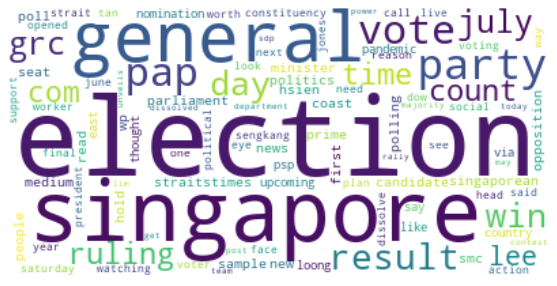

In [31]:
# generate a wordcloud
dictionary=Counter(text)
cloud = WordCloud(max_font_size=80,background_color='white', max_words=100).generate_from_frequencies(dictionary)
fig = plt.figure(figsize=(10,5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
fig.savefig("../img/wordcloud_neu.png",dpi=600, bbox_inches='tight')